<a href="https://colab.research.google.com/github/EmmanuelABonsu/CE888/blob/main/src/project/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras import models, layers, optimizers 
import matplotlib.pyplot as plt


from tensorflow.keras.applications import EfficientNetB0

In [16]:
# Defining file paths. Model data is stored in Google drive
train_path = "drive/MyDrive/CE888_data/Training"
test_path = "drive/MyDrive/CE888_data/Test"
img_dimension = (254, 254)

In [17]:
# Implemeneted generator to read in image files. This generator is only used for visualization
train_image_gen_visual = ImageDataGenerator(rescale=1./255)                                 
test_image_gen_visual = ImageDataGenerator(rescale=1./255)
preprocessing_train_generator = train_image_gen_visual.flow_from_directory(train_path, 
                                                   target_size = img_dimension, 
                                                   batch_size = 1,
                                                   class_mode = 'binary')
preprocessing_test_generator = test_image_gen_visual.flow_from_directory(test_path, 
                                                   target_size = img_dimension, 
                                                   batch_size = 1,
                                                   class_mode = 'binary')

Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [18]:
def show_sample_images(generator, image_title):
  fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(25,4))
  for i, ax in enumerate(axs.flatten()):
      img, label = generator.next()
      plt.sca(ax)
      plt.imshow(img[0])
      plt.title('Image: {}'.format(i+1))
  plt.suptitle(image_title)
  plt.show()

In [19]:
def plot_distribution_of_data(generator, image_tile):
  selectedClasses = list(generator.class_indices.keys())
  plot_dict = {}
  for cls in range(len (generator.class_indices)):  
    plot_dict[selectedClasses[cls]] = list(generator.classes).count(cls)
  plt.bar(range(len(plot_dict)), list(plot_dict.values()), align='center')
  plt.xticks(range(len(plot_dict)), list(plot_dict.keys()))
  plt.ylabel("Count")
  plt.title("Distribution of " + image_tile + " Data")

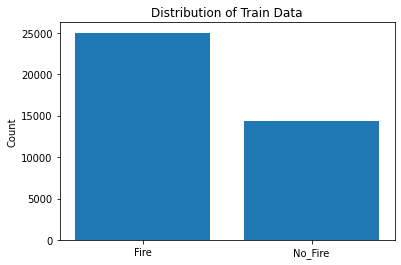

In [20]:
plot_distribution_of_data(preprocessing_train_generator, "Train")

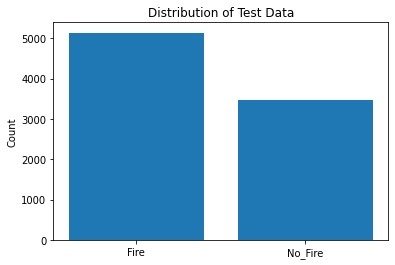

In [21]:
plot_distribution_of_data(preprocessing_test_generator, "Test")

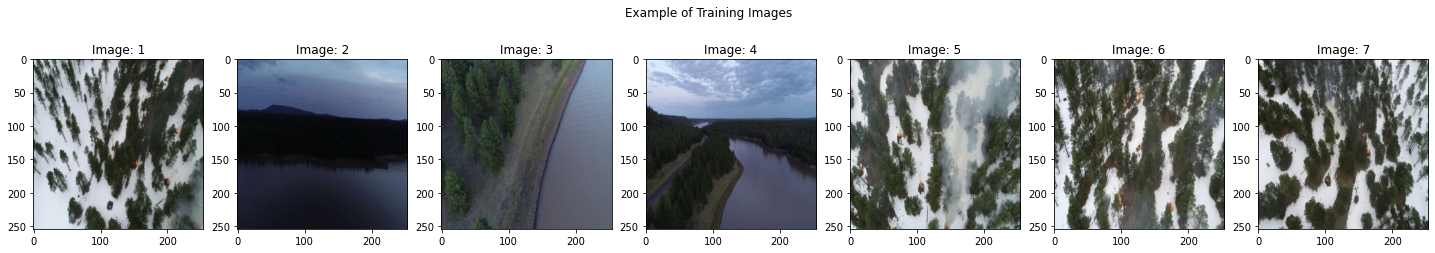

In [22]:
# Displaying example images from train dataset 
show_sample_images(preprocessing_train_generator, "Example of Training Images")

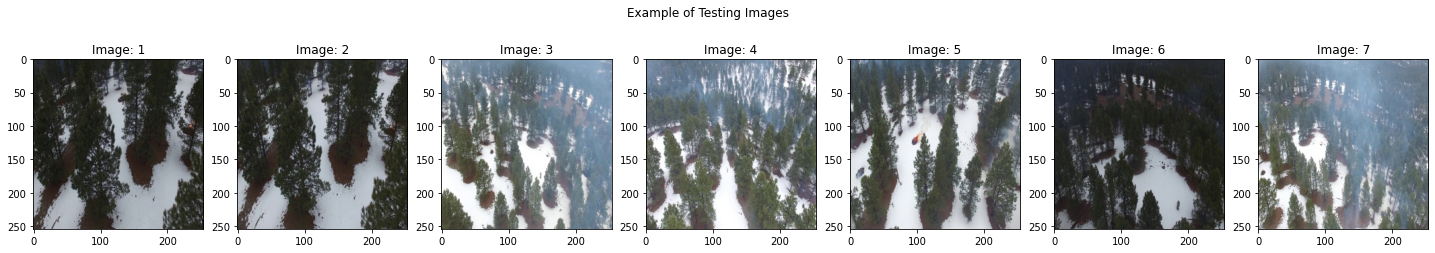

In [23]:
# Displaying example images from test dataset
show_sample_images(preprocessing_test_generator, "Example of Testing Images")

In [24]:
batch_size = 128
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3) # set validation split (70 - 30)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(254, 254),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(254, 254),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 27563 images belonging to 2 classes.
Found 11812 images belonging to 2 classes.


In [25]:
# show_sample_images(train_generator, "Preprocessed Images")
pre_trained_model = VGG16(
        weights='imagenet',
        include_top = False,
        input_shape=(254, 254, 3)
    )
pre_trained_model.summary()

# Building Custom model
for layer in pre_trained_model.layers:
  layer.trainable = False

model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 254, 254, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 254, 254, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 254, 254, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 63, 63, 128)       0     

In [26]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, workers=8)


Epoch 1/10
216/216 [==============================] - 604s 3s/step - loss: 0.4568 - acc: 0.9020 - val_loss: 0.1526 - val_acc: 0.9491
Epoch 2/10
216/216 [==============================] - 614s 3s/step - loss: 0.0265 - acc: 0.9924 - val_loss: 0.2031 - val_acc: 0.9487
Epoch 3/10
216/216 [==============================] - 606s 3s/step - loss: 0.0183 - acc: 0.9950 - val_loss: 0.1799 - val_acc: 0.9519
Epoch 4/10
216/216 [==============================] - 608s 3s/step - loss: 0.0135 - acc: 0.9959 - val_loss: 0.2017 - val_acc: 0.9438
Epoch 5/10
216/216 [==============================] - 606s 3s/step - loss: 0.0108 - acc: 0.9974 - val_loss: 0.1633 - val_acc: 0.9616
Epoch 6/10
216/216 [==============================] - 604s 3s/step - loss: 0.0103 - acc: 0.9974 - val_loss: 0.2963 - val_acc: 0.9429
Epoch 7/10
216/216 [==============================] - 591s 3s/step - loss: 0.0118 - acc: 0.9965 - val_loss: 0.2715 - val_acc: 0.9409
Epoch 8/10
216/216 [==============================] - 589s 3s/step - 

In [27]:
model.save('drive/MyDrive/trained_model/fire_dection_model_run_April_7')

INFO:tensorflow:Assets written to: drive/MyDrive/trained_model/fire_dection_model_run_April_7/assets


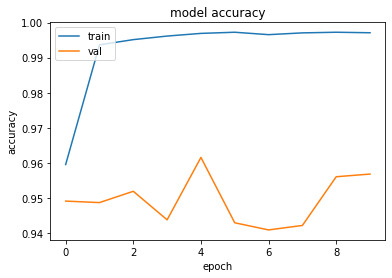

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

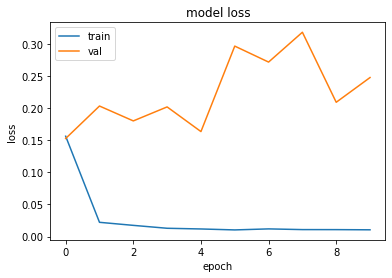

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()